### Forgery exposure CNN model - without use of Transfer Learning

In [0]:
#!pip install numpy==1.16.1
# This version of numpy is needed for loading the np file which holds the pictures of signatures that will be used for modelling

In [0]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rn

import pathlib

from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import losses
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection

import os
import sys
import time

%matplotlib inline

import cv2

from google.colab.patches import cv2_imshow

import h5py

from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [0]:
# Setting up some random seeds
np.random.seed(7)
rn.seed(12345)
tf.set_random_seed(1234)

In [0]:
csv_fajl_1 = pd.read_csv("./drive/My Drive/signature-data/all signatures with flags preimenovani.csv")
y = csv_fajl_1["flag_if_forge"]
csv_fajl_1.head()

,signatures,flag_if_forge
0,014_forg/01_0102014.png,1
1,014_forg/02_0102014.png,1
2,014_forg/03_0102014.png,1
3,014_forg/04_0102014.png,1
4,004_forg/02_0103004.png,1


In [0]:
# Loading the np file that holds the pictures
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
nr_pictures = len(dataset_old)
nr_pictures

1649

In [0]:
HEIGHT = 244
WIDTH = 244

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
dataset_resized.shape

(1649, 244, 244, 3)

In [0]:
# Resizing the pictures to 244x244 
for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
dataset_resized = []

In [0]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.111, random_state=42, stratify=y_train)

In [0]:
# Preprocessing

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

In [0]:
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print()
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)
print()
print("X val shape: ", X_val.shape)
print("y val shape: ", y_val.shape)

X train shape:  (1319, 244, 244, 3)
y train shape:  (1319,)

X test shape:  (165, 244, 244, 3)
y test shape:  (165,)

X val shape:  (165, 244, 244, 3)
y val shape:  (165,)


In [0]:
# One hot encoding
def one_hot(y, C):
  y_one_hot = np.zeros((y.shape[0], C))
  y_one_hot[np.arange(0, y.shape[0]), y] = 1
    
  return y_one_hot

In [0]:
# Number of categories
C = 2

In [0]:
# Encoding the targets
y1_train = one_hot(y_train, C)
y1_test = one_hot(y_test, C)
y1_val = one_hot(y_val, C)

In [0]:
print("y train shape: ", y1_train.shape)
print()
print("y test shape: ", y1_test.shape)
print()
print("y val shape: ", y1_val.shape)

y train shape:  (1319, 2)

y test shape:  (165, 2)

y val shape:  (165, 2)


In [0]:
input_shape = X_train.shape[1:]
input_shape

(244, 244, 3)

In [0]:
# Final model architecture

In [0]:
def build_model_2():
  x_input = Input(input_shape)

  x = ZeroPadding2D(padding = (1,1))(x_input)
  x = Conv2D(64, kernel_size = (5,5), strides = (1,1) , padding='same')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation("relu")(x)

  x = AveragePooling2D(pool_size = (2,2))(x)

  x = ZeroPadding2D(padding = (1,1))(x)
  x = Conv2D(128, kernel_size = (5,5), strides = (1,1), padding='same')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation("relu")(x)

  x = AveragePooling2D(pool_size = (2,2))(x)

  x = Flatten()(x)
  x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x)
  x = Dense(256, activation="relu", kernel_regularizer=l2(2e-3))(x)
  preds = Dense(C, activation="softmax")(x)

  model = Model(inputs=x_input, outputs=preds)

  return model

In [0]:
model_2 = build_model_2()

In [0]:
# Difference between model_1 and model_2 is that model_2 doesn't have Dropout layers

In [0]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 246, 246, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 246, 246, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 246, 246, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 123, 123, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 125, 125, 64)      0   

In [0]:
model_2.compile(optimizer=SGD(lr=0.0001, nesterov=True), loss="binary_crossentropy", metrics=["acc"])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Training the model_2

In [0]:
epochs = 10
batch_size = 32
verbose = 1

In [0]:
callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto')]

t=time.time()

In [0]:
history = model_2.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    callbacks=callbacks,
                    validation_data = (X_val,y1_val)
                    )
    
print('Training time: %s' % (time.time()-t))

Train on 1319 samples, validate on 165 samples
Epoch 1/10
1319/1319 [==============================] - 521s 395ms/step - loss: 2.2217 - acc: 0.5648 - val_loss: 2.3290 - val_acc: 0.4788
Epoch 2/10
1319/1319 [==============================] - 518s 392ms/step - loss: 2.1397 - acc: 0.6785 - val_loss: 2.2070 - val_acc: 0.6182
Epoch 3/10
1319/1319 [==============================] - 507s 384ms/step - loss: 2.0809 - acc: 0.7324 - val_loss: 2.1978 - val_acc: 0.6303
Epoch 4/10
1319/1319 [==============================] - 520s 394ms/step - loss: 2.0634 - acc: 0.7536 - val_loss: 2.1307 - val_acc: 0.6848
Epoch 5/10
1319/1319 [==============================] - 506s 384ms/step - loss: 2.0201 - acc: 0.7877 - val_loss: 2.0972 - val_acc: 0.7030
Epoch 6/10
1319/1319 [==============================] - 506s 384ms/step - loss: 1.9762 - acc: 0.8264 - val_loss: 2.1220 - val_acc: 0.6606
Epoch 7/10
1319/1319 [==============================] - 506s 384ms/step - loss: 1.9481 - acc: 0.8355 - val_loss: 2.1475 - val

In [0]:
# Saving the model history on Google Drive
model_num = "model-2"
checkpoints_path1 = './drive/My Drive/checkpoints/sign/'+'checkpoint-'+model_num+'-history.txt'
f = open(checkpoints_path1,"w")
f.write( str(history.history) )
f.close()

In [0]:
epochs = history.epoch

In [0]:
history = history.history

In [0]:
val_acc_hist = history["val_acc"]
val_loss_hist = history["val_loss"]
train_acc_hist = history["acc"]
train_loss_hist = history["loss"]

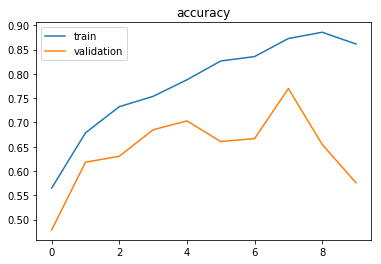

In [0]:
plt.title("accuracy")
plt.plot(epochs, train_acc_hist, label="train")
plt.plot(epochs, val_acc_hist, label = "validation")
plt.legend()

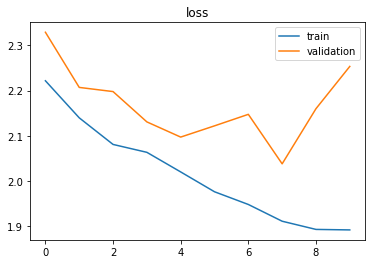

In [0]:
plt.title("loss")
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label = "validation")
plt.legend()

In [0]:
# From the graph, we can see that at epoch 5 validation acc starts being instable, and losses also
# so I choose to train the model on 5 epochs and use it as final model
val_acc_hist[4]

0.703030303030303

In [0]:
# Training on train+val

final_model_2 = build_model_2()

final_model_2.compile(optimizer=SGD(lr=0.0001, nesterov=True), loss="binary_crossentropy", metrics=["acc"])

model_num = 'final-model-2'

In [0]:
dataset_old = np.load('./drive/My Drive/signature-data/dataset_np.npy')

In [0]:
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

In [0]:
for i,image in enumerate(dataset_old):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [0]:
dataset_old = []

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_resized, y, test_size=0.1, random_state=42, stratify=y)

In [0]:
X_train = X_train/255
X_test = X_test/255
y1_train = one_hot(y_train,C)
y1_test = one_hot(y_test,C)

In [0]:
dataset_resized = []

In [0]:
epochs = 5
batch_size = 32
verbose = 1

checkpoints_path = './drive/My Drive/checkpoints/sign/'+'checkpoint-final-'+model_num+'ntl-epoch-{epoch:02d}.hdf5'
checkpoints_path1 = './drive/My Drive/checkpoints/sign/'+'checkpoint-final-'+model_num+'ntl-history.txt'

callbacks = [EarlyStopping(monitor='acc', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto')]

t=time.time()

In [0]:
history = final_model_2.fit(X_train,
                            y1_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=verbose
                            )
    
print('Training time: %s' % (time.time()-t))

Epoch 1/5
1484/1484 [==============================] - 556s 374ms/step - loss: 2.1974 - acc: 0.6058
Epoch 2/5
1484/1484 [==============================] - 552s 372ms/step - loss: 2.1154 - acc: 0.7116
Epoch 3/5
1484/1484 [==============================] - 549s 370ms/step - loss: 2.0587 - acc: 0.7621
Epoch 4/5
1484/1484 [==============================] - 551s 371ms/step - loss: 2.0034 - acc: 0.8093
Epoch 5/5
1484/1484 [==============================] - 570s 384ms/step - loss: 1.9793 - acc: 0.8147
Training time: 2785.411725759506


In [0]:
final_model_2.save("./drive/My Drive/checkpoints/sign/checkpoint-final-model-2-ntl.hdf5")

In [0]:
# genuine = positive -> 0
# forged = negative -> 1

# False Acceptance Rate
def FAR_acc(y, y_pred):
  FN = sum((y == 0) & (y_pred == 1))
  TP = sum((y == 0) & (y_pred == 0))
  return(FN / (FN + TP))


# False Rejection Rate
def FRR_acc(y, y_pred):
  FP = sum((y == 1) & (y_pred == 0))
  TN =  sum((y == 1) & (y_pred == 1))
  return(FP / (FP + TN))


# Both values should be as lower as possible, but with accent on FAR

In [0]:
def one_hot_decode(matrix):
  return np.array([list(row).index(1) for row in matrix])

In [0]:
def preds_decode(matrix):
  result = []
  for row in matrix:
    if row[0]>0.5:
      result.append(0)
    else: result.append(1)
  return np.array(result)

In [0]:
# TEST SET
test_loss, test_acc = final_model_2.evaluate(X_test, y1_test)

y_pred_test = final_model_2.predict(X_test)
y_pred_test_1 = preds_decode(y_pred_test)

test_FAR = FAR_acc(y_test, y_pred_test_1)
test_FRR = FRR_acc(y_test, y_pred_test_1)

165/165 [==============================] - 22s 132ms/step


In [0]:
print("Test Accuracy", test_acc)
print("Test FAR", test_FAR)
print("Test FRR", test_FRR)

Test Accuracy 0.7636363643588442
Test FAR 0.16853932584269662
Test FRR 0.3157894736842105


In [0]:
# Train Accuracy: 81%
# Validation Accuracy: 70%
# Test Accuracy: 76%

In [0]:
# Final results.

In [0]:
final_model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 246, 246, 64)      4864      
_________________________________________________________________
batch_normalization_3 (Batch (None, 246, 246, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 246, 246, 64)      0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 123, 123, 64)      0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 125, 125, 64)      0   

In [0]:
# Visualization of learned filters bellow

In [0]:
# path for saving the images
pathhh = "./drive/My Drive/"+model_num+"_"

In [0]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K

In [0]:
# !!! code from keras documentation


def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img(pathhh+'model_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)
        save_img('model_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)


    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

In [0]:
layer_names = ["conv2d_3", "conv2d_4"]

In [0]:
for LAYER_NAME in layer_names:
  visualize_layer(final_model_2, LAYER_NAME)

Compute filters 0 to 64
Costs of filter   0:     5 ( 3.55s )
Costs of filter   1:     5 ( 3.54s )
Costs of filter   2:     3 ( 3.50s )
Costs of filter   4:     5 ( 3.50s )
Costs of filter   7:    11 ( 3.51s )
Costs of filter   8:     6 ( 3.56s )
Costs of filter   9:     2 ( 3.55s )
Costs of filter  11:     8 ( 3.54s )
Costs of filter  12:     4 ( 3.56s )
Costs of filter  14:     3 ( 3.54s )
Costs of filter  15:     5 ( 3.54s )
Costs of filter  17:     6 ( 3.77s )
Costs of filter  19:     4 ( 3.60s )
Costs of filter  21:     6 ( 3.60s )
Costs of filter  23:     7 ( 3.58s )
Costs of filter  25:     2 ( 3.60s )
Costs of filter  26:     9 ( 3.65s )
Costs of filter  27:     9 ( 3.63s )
Costs of filter  28:     5 ( 3.74s )
Costs of filter  31:     3 ( 3.59s )
Costs of filter  32:     4 ( 3.63s )
Costs of filter  33:     7 ( 3.66s )
Costs of filter  34:    12 ( 3.63s )
Costs of filter  38:    10 ( 3.64s )
Costs of filter  40:     7 ( 3.82s )
Costs of filter  41:     5 ( 3.80s )
Costs of filte

In [0]:
im1 = cv2.imread("/content/model_conv2d_3_6x6.png")
im1 = np.array(im1)
im1 = cv2.resize(im1, (round(im1.shape[0]*0.3), round(im1.shape[1]*0.3)))

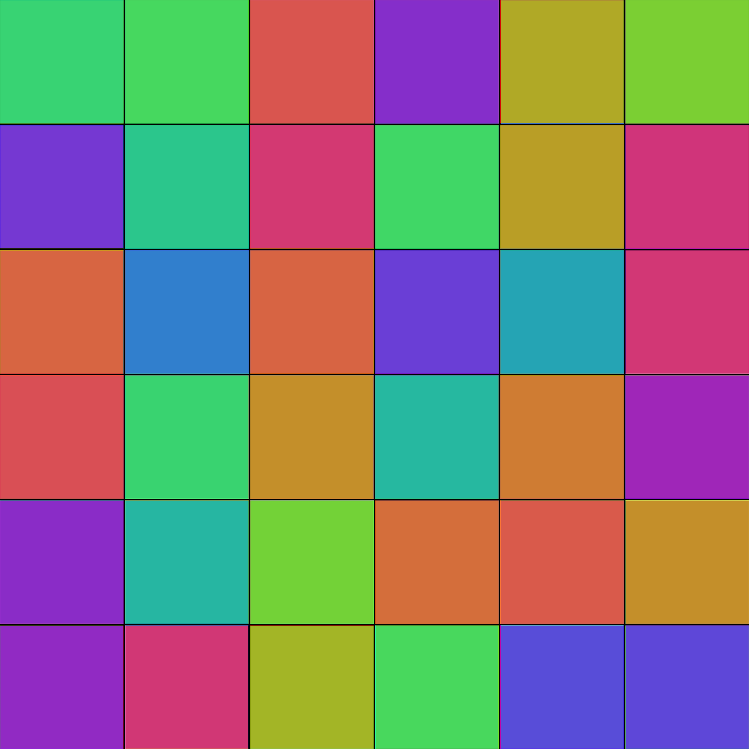

In [0]:
cv2_imshow(im1)

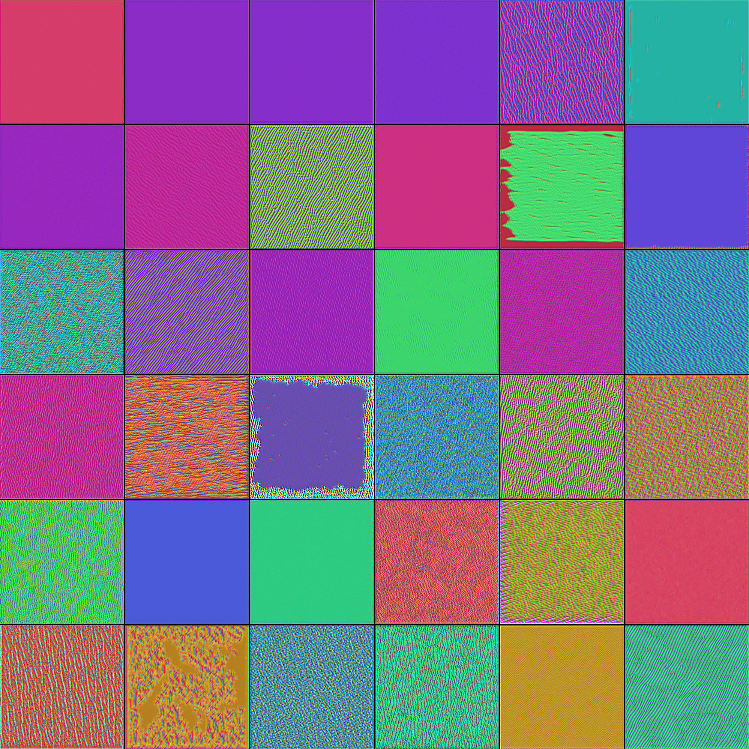

In [0]:
im2 = cv2.imread("/content/model_conv2d_4_6x6.png")
im2 = np.array(im2)
im2 = cv2.resize(im2, (round(im2.shape[0]*0.3), round(im2.shape[1]*0.3)))
cv2_imshow(im2)